## **Naive Bayes**
### **TF-IDF**


* Importation des librairies nécessaires

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.metrics import average_precision_score,precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
from sklearn.metrics import classification_report



ModuleNotFoundError: No module named 'seaborn'

## **Open and load the data set**

In [2]:


df = pd.read_csv("spam_ham_dataset.csv")
df



## **ham/spam repartition**

/home/tp-home009/bberken/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


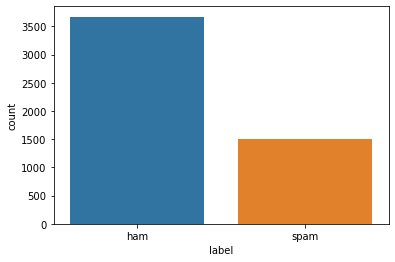

In [3]:
sn.countplot(df["label"])

## **Data set view**

In [4]:
df

(5171, 4)

## **View Exemple of data** 

In [5]:
df.iloc[0]


id                                                         605
label                                                      ham
text         Subject: enron methanol ; meter # : 988291\nth...
label_num                                                    0
Name: 0, dtype: object

### **Message content of the above element**

In [6]:

df.iloc[0]["text"]

"Subject: enron methanol ; meter # : 988291\nthis is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\nflow data provided by daren } .\nplease override pop ' s daily volume { presently zero } to reflect daily\nactivity you can obtain from gas control .\nthis change is needed asap for economics purposes ."

## **Remove unnecessary columns**

In [7]:
df.drop("id",axis=1,inplace=True)
df.drop("label",axis=1,inplace=True)



### **Remaining attribute of the datafram**

In [8]:
df

,text,label_num
0,Subject: enron methanol ; meter # : 988291\nth...,0
1,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\nthis deal is to ...,0
...,...,...
5166,Subject: put the 10 on the ft\nthe transport v...,0
5167,Subject: 3 / 4 / 2000 and following noms\nhpl ...,0
5168,Subject: calpine daily gas nomination\n>\n>\nj...,0
5169,Subject: industrial worksheets for august 2000...,0


## **Data Cleaning**
#### 1. *Remove Syntax*
#### 2. *Lowering Case*
#### 3. *Split Into An Array Of Word*
#### 4. *Remove StopWords*
#### 5. *Converting the word to its meaningful base*

In [9]:

ps = PorterStemmer()
lm = WordNetLemmatizer() 
#Le corpus qui va contenir la liste des messages (text) tout en minuscule sans la ponctuation et les stopwords
corpus = []
for i in range(0, len(df["text"])):
#Suppression de tout les caractéres spéciaux
    message = re.sub('[^a-zA-Z]', ' ',df["text"][i])
#Mettre tout le message en minuscule
    message = message.lower()
#Couper le message en mots
    message = message.split()
#Parcourir tout les mots de chaque message et les convertir en leurs forme de base significative s'il n'appratiennent pas au stops words
    message = [lm.lemmatize(word) for word in message if not word in stopwords.words('english')]
#Reformer le text de chaque message à partir des mots restant convertis en leurs forme de base signficative en miniscule et sans pontuation
    message = ' '.join(message)
#ajouter le message dans le corpus
    corpus.append(message)

### **TfidfVectorizer application on the corpus**

In [11]:
#Application de TfidVectorizer pour calculer le TF et le IDF de chaque mot du text de chaque message du corpus
#Multipler les valeurs TF*IDF pour avoir une valeur entre 0 et 1 qui représentera l'importance du mots dans le data set
#Chaque message du corpus deviendras une liste de float représentant les mots que ce dérnier contenais
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer()
X = cv.fit_transform(corpus).toarray()
X


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# **resampling**

Comme on travaille sur des données déséquilibrées : 
 * on appliquera sur nos données des méthodes de rééchantillonnage  : 
   * 1 => Génération d’échantillons synthétiques : qui consiste à générer des échantillons synthétiques de manière automatique et la également on distingue deux type d'algorithmes  :  
     * i => Les algorithmes de sur-échantillonnage en créant des échantillons synthétiques à partir de la classe minoritaire au lieu de créer de simples copies.
     * ii => Les algorithmes de Sous-échantillonnage en générant un certain nombre de centroïdes à partir des données d’origine, afin de perdre le moins d’information possible sur la classe majoritaire, lorsque celle-ci doit être réduite afin d’arriver à un ratio (classe minoritaire/ classe majoritaire) satisfaisant. 
   *  2 => Sur-échantillonnage : Oversampling  qui consiste à augmenter le nombre d'éléments de 
   la (des) classe(s) minoritaire(s) afin d’arriver à un ratio classe minoritaire/ classe majoritaire satisfaisant.
   * 3 => Sous-échantillonnage : Undersampling  qui consiste à diminuer le nombre d'éléments de la  (des) classe(s) majoritaire(s) afin d’arriver à un ratio classe minoritaire/ classe majoritaire satisfaisant. 
   
   

## **1) ii )**

* Synthetic undersampling(prend du temsp)

In [2]:
#ce modél de sous échantillonage synthetique prends énormément de temps pour s'excuter donc je ne l'ai pas inclus
#dans la démarche de résoltion de ce probléme ainsi qu'ayant un data set de taille 5000 il est conseillé d'utiliser le sur-échantillonage.
'''from imblearn.under_sampling import ClusterCentroids 
cc = ClusterCentroids()

X_SU, Y_SU = cc.fit_resample(X,df["label_num"])
print ("taille de x_bal : ",len(X_SU))
print ("taille de y_bal : ",len(Y_SU))'''

'from imblearn.under_sampling import ClusterCentroids \ncc = ClusterCentroids()\n\nX_SU, Y_SU = cc.fit_resample(X,df["label_num"])\nprint ("taille de x_bal : ",len(X_SU))\nprint ("taille de y_bal : ",len(Y_SU))'

## **MultinomialNB**

* Préparation de trois modéles MultinomialNB pour l'entrainement sur les train et test set qu'on on aura choisie par la suite 
issuent de l'application des trois modél d'échantillonage

In [53]:

model_SO = MultinomialNB()
model_CO = MultinomialNB()
model_CU = MultinomialNB()


## **1 ) i )**

## **Tests to extract the best value of "sampling_strategy" for Synthetic Oversampling**

* On appliquera l'entrainement et le test du modéle MultinomialNB sur plusieurs données reéchantillonées avec le même modéle mais avec une valuer du ratio de reéchantillonage différent pour choisir et fixer le meilleur ratio pour notre cas, et donc avoir la meilleure accuracy.

In [3]:
def accuracy_ratio(r):
#Définition du modéle de reéchantillonage synthetique avec le une valeur de ratio entrée en argument de la fonction 
    smk= SMOTETomek(sampling_strategy=r)
#Appliquer le reéchantillonage
    X_SO, Y_SO = smk.fit_resample(X,df["label_num"])
#Partager les données reéchantillonées en train et test set
#Appliquer l'entrainement du modél de prédiction 
# Predir avec ce dérnier et renvoiyer l'accuracy score 
    X_train_SO, X_test_SO, y_train_SO, y_test_SO = train_test_split(X_SO, Y_SO, test_size = 0.20, random_state = 0)
    model_SO.fit(X_train_SO,y_train_SO)
    y_pred_SO=model_SO.predict(X_test_SO)
    return accuracy_score(y_pred_SO,y_test_SO)

In [55]:
#Appliquer la fonction définis ci-dessus pour plusieurs ratio
x = [accuracy_ratio(i/10) for i in range(5,11)]
y = [(i/10) for i in range(5,11) ]

Text(0.5, 1.0, '-Accuracy en fonction du racio du rééchantillonage-')

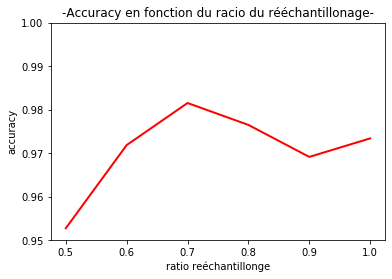

In [56]:
#Affichage de l'accuracy score en fonction du ratio
plt.plot(y,x, color = 'red', linestyle = 'solid', linewidth = 2,
  markerfacecolor = 'blue', markersize = 5)
plt.ylim(0.95, 1)
plt.xlabel('ratio reéchantillonge')
plt.ylabel('accuracy')
plt.title('-Accuracy en fonction du racio du rééchantillonage-')

## **Remarks**

* On remarque à partir du graphe ci-dessus, que l'accuracy varie en variant le ratio (Nb email/Nb spam) du reéchantillonage mais prés de 0.5 on a l'accuracy toujours proche de 0.95 et en 1 toujours fixe et plutôt prôche de 0.975.
Cette variation de valeurs à chaque excution est causé par la fonction trai_test_split qui prends à chaque excution de la fonction accuracy_ratio un nouveau découpage du data set (Corpus aprés application de TF-IDF).
* On aperçois également que l'accuracy la plus fixe à un une bonne valeur est atteinte lorsque le valeur du ratio = 1 , donc dans le cas ou les deux classes sont équilibrées (Nb mail = Nb spam)

* En s'appuyant sur les résultats et remarques faites dans la précédente cellule, on choisira le ratio = 1 pour le sur échantillonage sythetique 

## **Synthetic Oversampling application**

In [4]:
#On applique le sur-échantillonage synthétique avec le ratio = 1
smk= SMOTETomek(sampling_strategy=1)
X_SO, Y_SO = smk.fit_resample(X,df["label_num"])
print ("taille de x_bal : ",len(X_SO))
print ("taille de y_bal : ",len(Y_SO))

NameError: name 'SMOTETomek' is not defined

##  **Fititing & prediction with Synthetic Oversampling data**

In [1]:
#Entrainement et predicition sur les données résultantes du sur-échntillonage synthétique
X_train_SO, X_test_SO, y_train_SO, y_test_SO = train_test_split(X_SO, Y_SO, test_size = 0.20, random_state = 0)
model_SO.fit(X_train_SO,y_train_SO)
y_pred_SO=model_SO.predict(X_test_SO)

NameError: name 'train_test_split' is not defined

# *Results*

* Accuracy

In [61]:
print("L'accuracy score de la prediction avec les données resultante du sur-échantillonage synthetique : "'AP={0:0.2f}'.format(accuracy_score(y_pred_SO,y_test_SO)))


Accuracy score for prediction with data resulting by Synthetic Oversampling data
 0.9652825051055139


 * L'accuracy est trés hautes et elle est à seulement 3% de la perfection(100%)

* Confusion matrix

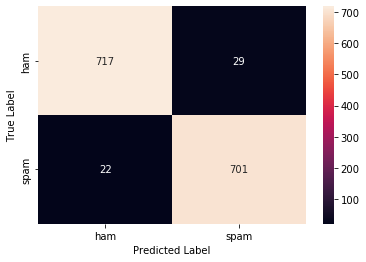

In [62]:
data = {'y_Actual':    y_test_SO.values,
        'y_Predicted': y_pred_SO
        }
d = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(d['y_Actual'], d['y_Predicted'], rownames=['True Label'], colnames=['Predicted Label'])
sn.heatmap(confusion_matrix, annot=True,fmt='d',xticklabels=['ham','spam'], yticklabels=['ham','spam'])
plt.show()

* Score details

In [104]:
print (classification_report(y_test_SO, y_pred_SO))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       746
           1       0.96      0.97      0.96       723

    accuracy                           0.97      1469
   macro avg       0.97      0.97      0.97      1469
weighted avg       0.97      0.97      0.97      1469



* On remarque de la matrice de confusion et les détails du score que : 
    * Le modéle a prédit : 
        * Pour les mails  : 
            * 717 mail de 746 (les vrais postifs) => precision => 0.97
            * 22 spam en étant des mail (les faux positifs)
            * 29 mail en étant des spam (les faux négatifs) => recall = 0.96
        * Pour les spams :  
            * 701 spam de 723 (les vrais postifs)precision => 0.96
            * 29 mail en étant des spam (les faux positifs)
            * 22 spam en étant des mail (les faux négatifs)=> recall = 0.97


* Comme on a une quantité de données importante, les résultat de la précision et du rappel sont satisfaisants car sur l'ensemble de données il y en a trés peu de mail qui passe en spam(ce qui est un peu grave sur une quantité mois importante de donées) et peu de spam qui passe en mail (ce n'est pas trop grave).
    

* average precisiion & auc precision recall

In [103]:
average_precision_SO = average_precision_score(y_true=y_test_SO, y_score=y_pred_SO)
precision_SO, recall_SO, thresholds_SO = precision_recall_curve(y_test_SO, y_pred_SO)
auc_precision_recall_SO = auc(recall_SO, precision_SO)
print('La valeur de l''average precision est : ''AP={0:0.2f}'.format(average_precision_SO))
print('La valeur de l''air sous la courbe de precision et rappelle est : ''AP={0:0.2f}'.format(auc_precision_recall_SO))

0.9460301919646419
0.9724106889264844


Text(0.5, 1.0, 'SSO Precision-Recall curve: AP=0.95')

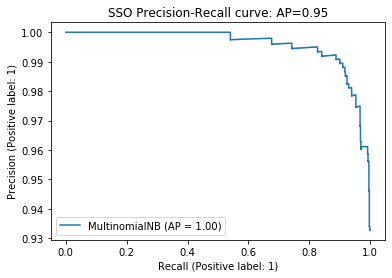

In [106]:

disp = plot_precision_recall_curve(model_SO, X_test_SO, y_test_SO)
disp.ax_.set_title('SSO Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision_SO))

* On voit sur la courbe qu'elle est presque parfaite, car la precision et le rappelle de ce dérnier sont trés elevés,ainni qu'on peut apercevoir du bruit de precison te rappelle prés de  1 car ces dérnier ne sont pas tout à fait parfait.

# **2)**

## **Tests to extract the best value of "sampling_strategy" for Classique Oversampling**

In [7]:
def accuracy_ratio(r):
#Définition du modéle de reéchantillonage classique avec le une valeur de ratio entrée en argument de la fonction 
    ros = RandomOverSampler(sampling_strategy=r)
#Appliquer le reéchantillonage
    X_CO, Y_CO = ros.fit_resample(X,df["label_num"])
#Partager les données reéchantillonées en train et test set
#Appliquer l'entrainement du modél de prédiction 
#Predir avec ce dérnier et renvoiyer l'accuracy score 
    X_train_CO, X_test_CO, y_train_CO, y_test_CO = train_test_split(X_CO, Y_CO, test_size = 0.20, random_state = 0)
    model_CO.fit(X_train_CO,y_train_CO)
    y_pred_CO=model_CO.predict(X_test_CO)
    return accuracy_score(y_pred_CO,y_test_CO)

In [65]:
#Appliquer la fonction définis ci-dessus pour plusieurs ratio
x = [accuracy_ratio(i/10) for i in range(5,11)]
y = [(i/10) for i in range(5,11)]

Text(0.5, 1.0, '-Accuracy en fonction du racio du rééchantillonage-')

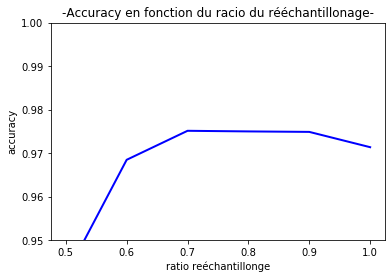

In [67]:
#Affichage de l'accuracy score en fonction du ratio
plt.plot(y,x, color = 'blue', linestyle = 'solid', linewidth = 2,
  markerfacecolor = 'blue', markersize = 5)
plt.ylim(0.95, 1)
plt.xlabel('ratio reéchantillonge')
plt.ylabel('accuracy')

plt.title('-Accuracy en fonction du racio du rééchantillonage-')

## **Remarks**

 * Mêmes remrques pour le model d'échantillonage précédent le meilleur ratio est r =0.9 pi r = 1

## **Classic Oversampling application**

In [2]:
#On applique le sur-échantillonage classique avec le ratio = 1
ros = RandomOverSampler(sampling_strategy=1)
X_CO, Y_CO = ros.fit_resample(X,df["label_num"])

print ("taille de x_bal : ",len(X_CO))
print ("taille de y_bal : ",len(Y_CO))

NameError: name 'RandomOverSampler' is not defined

## **Fititing & prediction with classic Oversampling data**


In [3]:
#Entrainement et predicition sur les données résultantes du sur-échantillonage classique
X_train_CO, X_test_CO, y_train_CO, y_test_CO = train_test_split(X_CO, Y_CO, test_size = 0.20, random_state = 0)
model_CO.fit(X_train_CO,y_train_CO)
y_pred_CO=model_CO.predict(X_test_CO)

NameError: name 'train_test_split' is not defined

# *Results*

* Acuuracy

In [70]:

print("Accuracy score:for prediction with data resulting by classic Oversampling data : "'AP={0:0.2f}'.format(accuracy_score(y_pred_CO,y_test_CO)))

Accuracy score:for prediction with data resulting by Classique Oversampling data
 0.9734513274336283


* L'accuracy obtnue est presque égale à celle obtenue en utilsant le réchantillonage synthetique.

* Confusion matrix

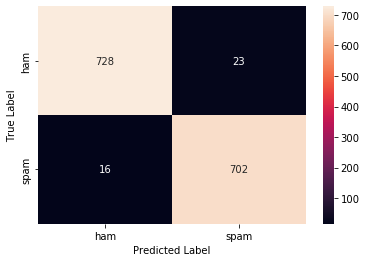

In [71]:
data = {'y_Actual':    y_test_CO.values,
        'y_Predicted': y_pred_CO
        }
d = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(d['y_Actual'], d['y_Predicted'], rownames=['True Label'], colnames=['Predicted Label'])
sn.heatmap(confusion_matrix, annot=True,fmt='d',xticklabels=['ham','spam'], yticklabels=['ham','spam'])
plt.show()

* Score details

In [101]:
print (classification_report(y_test_CO, y_pred_CO))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       751
           1       0.97      0.98      0.97       718

    accuracy                           0.97      1469
   macro avg       0.97      0.97      0.97      1469
weighted avg       0.97      0.97      0.97      1469



* On remarque de la matrice de confusion et les détails du score que : 
    * Le modéle a prédit : 
        * Pour les mails  : 
            * 728 mail de 751 (les vrais postifs) => precision => 0.98
            * 16 spam en étant des mail (les faux positifs)
            * 23 mail en étant des spam (les faux négatifs) => recall = 0.97
        * Pour les spams :  
            * 702 spam de 718 (les vrais postifs)precision => 0.97
            * 23 mail en étant des spam (les faux positifs)
            * 16 spam en étant des mail (les faux négatifs)=> recall = 0.98


* Vu la quantité de données importantes, les valeurs de la précision, recall et l'accuracy sont trés bonne valeurs qui démontre que le modél est bien entrainer.

 * average precision & precision recall curve

In [99]:
average_precision_CO = average_precision_score(y_true=y_test_CO, y_score=y_pred_CO)
precision_CO, recall_CO, thresholds_CO = precision_recall_curve(y_test_CO, y_pred_CO)
auc_precision_recall_CO = auc(recall_CO, precision_CO)
print('La valeur de l''average precision est : ''AP={0:0.2f}'.format(average_precision_CO))
print('La valeur de l''air sous la courbe de precision et rappelle est : ''AP={0:0.2f}'.format(auc_precision_recall_CO))

0.9575904471882943
0.9784417513052219


Text(0.5, 1.0, 'COS Precision-Recall curve: AP=0.96')

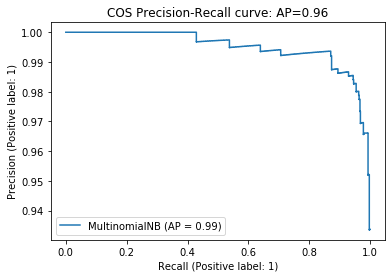

In [108]:
disp = plot_precision_recall_curve(model_CO, X_test_CO, y_test_CO)
disp.ax_.set_title('COS Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision_CO))

* On voit sur la courbe qu'elle est également presque parfaite mais avec un peu plus de bruit prés de 1 que la courbe obtenue par la prediction faite sur les données issues du sur-échantillonage synthetique. 

## **3 )**

## **Tests to extract the best value of "sampling_strategy" for Classique Undersampling**

In [72]:
def accuracy_ratio(r):
#Définition du modéle de reéchantillonage classique avec le une valeur de ratio entrée en argument de la fonction 
    rus = RandomUnderSampler(sampling_strategy=r)
#Appliquer le reéchantillonage
    X_CU, Y_CU = rus.fit_resample(X,df["label_num"])
#Partager les données reéchantillonées en train et test set
#Appliquer l'entrainement du modél de prédiction 
#Predir avec ce dérnier et renvoiyer l'accuracy score 
    X_train_CU, X_test_CU, y_train_CU, y_test_CU = train_test_split(X_CU, Y_CU, test_size = 0.20, random_state = 0)
    model_CU.fit(X_train_CU,y_train_CU)
    y_pred_CU=model_CU.predict(X_test_CU)
    return accuracy_score(y_pred_CU,y_test_CU)

In [78]:
#Appliquer la fonction définis ci-dessus pour plusieurs ratio
x = [accuracy_ratio(i/10) for i in range(5,11)]
y = [(i/10) for i in range(5,11)]

Text(0.5, 1.0, '-Accuracy en fonction du racio du rééchantillonage-')

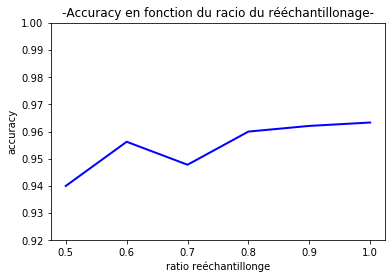

In [79]:
#Affichage de l'accuracy score en fonctio du ratio 
plt.plot(y,x, color = 'blue', linestyle = 'solid', linewidth = 2,
  markerfacecolor = 'blue', markersize = 5)
plt.ylim(0.92, 1)
plt.xlabel('ratio reéchantillonge')
plt.ylabel('accuracy')

plt.title('-Accuracy en fonction du racio du rééchantillonage-')

# **Remarks**

* Pour ce modéle on remrque que la meilleure valeur du ratio est toujours 1, donc on prendra la valeur 1 pour le paramétre ratio lors du reéchantillonage avec ce modéle

## **Classic Undersampling application**

In [4]:
#On applique le sous-échantillonage classique avec le ratio = 1
rus = RandomUnderSampler(sampling_strategy=1)
X_CU, Y_CU = rus.fit_resample(X,df["label_num"])

print ("taille de x_bal : ",len(X_CU))
print ("taille de y_bal : ",len(Y_CU))

NameError: name 'RandomUnderSampler' is not defined

# **Fititing & prediction with Classique Undersampling data**

In [5]:
#Entrainement et predicition sur les données résultantes du sous-échantillonage classique
X_train_CU, X_test_CU, y_train_CU, y_test_CU = train_test_split(X_CU, Y_CU, test_size = 0.20, random_state = 0)
model_CU.fit(X_train_CU,y_train_CU)
y_pred_CU=model_CU.predict(X_test_CU)

NameError: name 'train_test_split' is not defined

# *Results*

* Accuracy

In [6]:
print("Accuracy score for prediction with data resulting by Classic Undersampling data : "'AP={0:0.2f}'.format(accuracy_score(y_pred_CU,y_test_CU)))


NameError: name 'accuracy_score' is not defined

 * L'accuracy de ce modéle est légerement moins bonne(1% en moins) en comparant avec l'accuracy obtenue en entrainant les données resultantes des deux modéles de sur-échantillonage 

* Confusion matrix

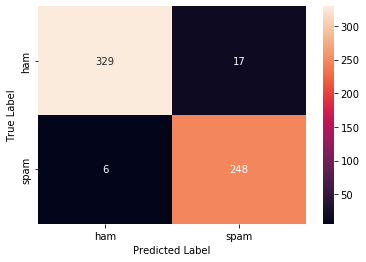

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       346
           1       0.94      0.98      0.96       254

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600



In [95]:
data = {'y_Actual':    y_test_CU.values,
        'y_Predicted': y_pred_CU
        }
d = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(d['y_Actual'], d['y_Predicted'], rownames=['True Label'], colnames=['Predicted Label'])
sn.heatmap(confusion_matrix, annot=True,fmt='d',xticklabels=['ham','spam'], yticklabels=['ham','spam'])
plt.show()





 * Score details

In [96]:
print (classification_report(y_test_CU, y_pred_CU))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       346
           1       0.94      0.98      0.96       254

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600



* On remarque de la matrice de confusion et les détails du score que : 
    * Le modéle a prédit : 
        * Pour les mails  : 
            * 329 mail de 346 (les vrais postifs) => precision => 0.98
            * 6 spam en étant des mail (les faux positifs)
            * 17 mail en étant des spam (les faux négatifs) => recall = 0.95
        * Pour les spams :  
            * 248 spam de 236 (les vrais postifs)precision => 0.94
            * 17 mail en étant des spam (les faux positifs)
            * 6 spam en étant des mail (les faux négatifs)=> recall = 0.98


* On remarques qu'avec moins de données, le nombre de mail classé comme spam (vis vers ça) diminue, c'est pourquoi on a obtenue une haute valeur de précision et de recall.

* average precision & auc precision recall

In [97]:
average_precision_CU = average_precision_score(y_true=y_test_CU, y_score=y_pred_CU)
precision_CU, recall_CU, thresholds_CU = precision_recall_curve(y_test_CU, y_pred_CU)
auc_precision_recall_CU = auc(recall_CU, precision_CU)
print('La valeur de l''average precision est : ''AP={0:0.2f}'.format(average_precision_CU))
print('La valeur de l''air sous la courbe de precision et rappelle est : ''AP={0:0.2f}'.format(auc_precision_recall_CU))

0.9237423859753381
0.9611135046798396


Text(0.5, 1.0, 'CSU Precision-Recall curve: AP=0.92')

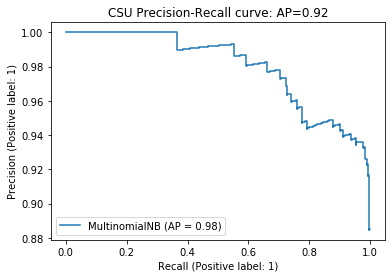

In [110]:
disp = plot_precision_recall_curve(model_CU, X_test_CU, y_test_CU)
disp.ax_.set_title('CSU Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision_CU))

* On peut facilement remarquer que la courbe contient beaucoup plus de bruit (des erreurs de precision et rappel) par rapport au deux courbes précédentes, ce qui est logique car les scores obtenus en utilisant les données issues de ce sous-échantillonage classique sont légérement moins bon que ceux obtenues avec les deux précédents modéles.

## **Results**
   

In [13]:
plt.plot(recall_SO, precision_SO)
plt.plot(recall_CO, precision_CO)
plt.plot(recall_CU, precision_CU)
plt.show()

NameError: name 'recall_SO' is not defined

* On remarque que l'air sous la  courbe de recall et precision du modéle entrainé avec les données reéchantillonées en sur-échantillonage synthetique est plus proche de 1 par rapport au deux autres modéle dévellopés avec les deux autres méthodes de reéchantillonage, ce qui montre que le sur-échantillonage synthetic est la meilleure méthode pour équilibrer les données dans notre cas avec le meilleur ratio = 1 .


## **Conclusion**

* Vu que : l'accuracy, la precision , le recall, l'air sous la courbe de l'application de classic Oversampling et classic Undersampling sont moins bon par rapport au résultat de l'application du model sur le résultats des données de la méthode synthetic oversampling, on choisie les résultats de cette déniére.